# Running Sentiment Analysis on tweets during shutdown and reopening  phases

In this notebook, we use `vaderSentiment` to conduct sentiment analysis on all tweets and visualize the results. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.style as style
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
import pytz

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# Link to this Sentiment Analyzer: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

In [2]:
tqdm.pandas() # Allows us to see progress bars on pandas.apply methods

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
style.use('fivethirtyeight')

In [4]:
# Reading in state shutdown data

base_url='./data/sentiment_data'

il_shutdown_df = pd.read_csv(f'{base_url}/IL_shutdown_sentiment.csv', low_memory=False, index_col='date')
ga_shutdown_df = pd.read_csv(f'{base_url}/GA_shutdown_sentiment.csv', low_memory=False, index_col='date')
fl_shutdown_df = pd.read_csv(f'{base_url}/FL_shutdown_sentiment.csv', low_memory=False, index_col='date')
tx_shutdown_df = pd.read_csv(f'{base_url}/TX_shutdown_sentiment.csv', low_memory=False, index_col='date')
mi_shutdown_df = pd.read_csv(f'{base_url}/MI_shutdown_sentiment.csv', low_memory=False, index_col='date')

In [5]:
# Reading in state reopening data

il_reopen_df = pd.read_csv(f'{base_url}/IL_reopen_sentiment.csv', low_memory=False, index_col='date')
fl_reopen_df = pd.read_csv(f'{base_url}/FL_reopen_sentiment.csv', low_memory=False, index_col='date')
ga_reopen_df = pd.read_csv(f'{base_url}/GA_reopen_sentiment.csv', low_memory=False, index_col='date')
tx_reopen_df = pd.read_csv(f'{base_url}/TX_reopen_sentiment.csv', low_memory=False, index_col='date')
mi_reopen_df = pd.read_csv(f'{base_url}/MI_reopen_sentiment.csv', low_memory=False, index_col='date')
oh_reopen_df = pd.read_csv(f'{base_url}/OH_reopen_sentiment.csv', low_memory=False, index_col='date')

In [6]:
def set_index_datetime_in_timezone(data, timezone):
    '''
    Takes a list of dataframes formatted [dataframe, timezone]
    Sets index of each dataframe to datetime and sorts the dataframe
    
    See pytz.timezone() documentation for all acceptable timezones.
    For the US, use the following:
    
    US/Central
    US/Eastern
    US/Mountain
    US/Pacific
    '''
    
    # Create datetime in local timezone
    try:
        data.index = pd.to_datetime(data.index).tz_localize('utc') # try to localize as utc, inconsistent data collection meant that some of the time codes lost their timezone assignment
        data.sort_index(inplace=True)
        data.index = data.index.tz_convert(timezone)
        
    # If the timezone is not naive (has a timezone assigned), we'll move to the code below
    except:
        data.index = pd.to_datetime(data.index)
        data.sort_index(inplace=True)
        data.index = data.index.tz_convert(timezone)


In [9]:
df_list = [
    [il_shutdown_df, 'US/Central'],
    [fl_shutdown_df, 'US/Eastern'],
    [ga_shutdown_df, 'US/Eastern'],
    [tx_shutdown_df, 'US/Eastern'],
    [mi_shutdown_df, 'US/Eastern'],
    [mi_reopen_df, 'US/Eastern'],
    [oh_reopen_df, 'US/Eastern'],
    [il_reopen_df, 'US/Central'],
    [fl_reopen_df, 'US/Eastern'],
    [ga_reopen_df, 'US/Eastern'],
    [tx_reopen_df, 'US/Eastern']
]

for df in tqdm(df_list):
    set_index_datetime_in_timezone(df[0], df[1])

100%|██████████| 11/11 [02:18<00:00, 12.58s/it]


In [10]:
# Copying over the covid terms from scraping so we can filter by these terms

il_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'springfield', 'pritzker', 'virus']
fl_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'desantis', 'virus', 'desantis']
ga_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'atlanta', 'kemp', 'virus']
tx_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'austin', 'abbott', 'virus']
mi_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'austin', 'whittmer', 'whitmer', 'virus']
mi_covid_terms = ['pandemic', 'coronavirus', 'news', 'health', 'covid', '19', 'quarantine', 'governor', 'capitol', 'austin', 'ginter', 'ginther', 'virus']

In [11]:
# Now we'll join these so the way we call them later doesn't look a mess

il_shutdown_df_covid = il_shutdown_df.copy()[il_shutdown_df['text'].str.contains('|'.join(il_covid_terms))]
ga_shutdown_df_covid = ga_shutdown_df.copy()[ga_shutdown_df['text'].str.contains('|'.join(ga_covid_terms))]
fl_shutdown_df_covid = fl_shutdown_df.copy()[fl_shutdown_df['text'].str.contains('|'.join(fl_covid_terms))]
tx_shutdown_df_covid = tx_shutdown_df.copy()[tx_shutdown_df['text'].str.contains('|'.join(tx_covid_terms))]
mi_shutdown_df_covid = mi_shutdown_df.copy()[mi_shutdown_df['text'].str.contains('|'.join(mi_covid_terms))]

il_reopen_df_covid = il_reopen_df.copy()[il_reopen_df['text'].str.contains('|'.join(il_covid_terms))]
ga_reopen_df_covid = ga_reopen_df.copy()[ga_reopen_df['text'].str.contains('|'.join(ga_covid_terms))]
fl_reopen_df_covid = fl_reopen_df.copy()[fl_reopen_df['text'].str.contains('|'.join(fl_covid_terms))]
tx_reopen_df_covid = tx_reopen_df.copy()[tx_reopen_df['text'].str.contains('|'.join(tx_covid_terms))]

In [12]:
# provided from link 
def sentiment_analyzer_scores(sentence):    
    score = analyser.polarity_scores(sentence)
    return score

In [13]:
# Analyze our city data
def vader_analyzer(data):
    '''
    Takes pandas dataframe of info scraped from twitter and performs sentiment
    analysis. Creates 5 new columns to be used in sentiment analysis:
    'neg_score' - negative score
    'neu_score' - neutral score
    'pos_score' - positive score
    'compound_score' - (score < -0.05 = negative
                        score between -0.05 and 0.05 = neutral
                        score > 0.05 = positive)
    '''
    
    # Note that progress_apply is a part of the tqdm library, which just allows us to track progress on the pandas .apply() method
    data['sentiment_analysis'] = data.progress_apply(lambda x: sentiment_analyzer_scores(x['text']), axis=1) # Creates a dictionary of the scores
    data['neg_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['neg']) # pulls the negative score from the dictionary
    data['neu_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['neu']) # pulls the neutral score from the dictionary
    data['pos_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['pos']) # pulls the positive score from the dictionary
    data['compound_score'] = data['sentiment_analysis'].progress_apply(lambda x: x['compound']) # pulls the compound score from the dictionary

In [14]:
def create_time_cols(data, timezone):
    # Creating month_day_hour column for graphing purposes
    data['month_day_hour'] = data.index.strftime(date_format='%m%d%H')

In [28]:
def plot_state_sentiment(data, timezone, covid_only=False, is_reopen=False):
    # Creating this variable for x tick marks
    hour_group = data.resample('h').mean()[['compound_score']]
    hour_group['hour_ord'] = range(0, len(hour_group)) # Hour ordinal column for graphing
    days = data.resample('D').mean().index.strftime('%m-%d')
    
    # Stores the shutdown and reopening dates as YYYYMMDD integers
    timeline_dict = {
        'FL': ['2020-04-01', '2020-04-29'],
        'TX': ['2020-03-31', '2020-05-18'],
        'NJ': ['2020-03-16', '2020-06-09'],
        'NY': ['2020-03-22', '2020-06-13'],
        'IL': ['2020-03-20', '2020-05-29'],
        'GA': ['2020-04-02', '2020-06-01'],
        'OH': ['2020-03-22', '2020-05-12'],
        'MI': ['2020-03-23', '2020-06-01']
    }
    
    # Stores the timezone offset
    timezone_map = {'eastern': -4,
                'central': -5,
                'mountain': -6,
                'pacific': -7}

    # Create sentiment plot
    fig, ax = plt.subplots(figsize=(32, 6))

    sns.lineplot(data=data,
                 x='month_day_hour',
                 y='compound_score', 
                 linewidth=2.5, 
                 color='blue',
                )

    plt.axhspan(-.05, .05, color='gray', alpha=0.3)
    plt.axhspan(.05, np.percentile(data['compound_score'], 90), color='green', alpha=0.3)
    plt.axhspan(-.05, np.percentile(data['compound_score'], 10), color='red', alpha=0.3)

    plt.xticks(range(-(24 + timezone_map[timezone]), # Need to offset the xticks to account for timezone shift upon scraping 
                         len(hour_group), # hour_group is just the original data grouped by hour, should be divisible by 24
                         24),
                   days.unique())

    ticks = ax.get_xticks().tolist()
    
    # Sorry this isn't human readable :( it returns the date in the proper format to be plotted
    plt.axvline(hour_group[timeline_dict[data['state'][0]][is_reopen]]['hour_ord'][0]) 
    
    plt.legend(['_', 'Date shutdown was announced'])
    
    # If the state is reopened
    if is_reopen:
        plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time In Tweets With Covid-Specific Terms Around Bars Reopening Announcement')
        if covid_only:
            plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time In Tweets With Covid-Specific Terms Around Bars Reopening Announcement')
        else:
            plt.title(f'{data["state"].reset_index().loc[0, "state"]} General Tweet Sentiment Over Time Around Bars Reopening Announcement')
    
    # If the state is not reopened
    else:
        plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time In Tweets With Covid-Specific Terms Around State Shutdown Announcement')
        if covid_only:
            plt.title(f'{data["state"].reset_index().loc[0, "state"]} Sentiment Over Time In Tweets With Covid-Specific Terms Around State Shutdown Announcement')
        else:
            plt.title(f'{data["state"].reset_index().loc[0, "state"]} General Tweet Sentiment Over Time Around State Shutdown Announcement')
            
    plt.xlabel('Date')
    plt.ylabel('Compound Score')

In [29]:
def analyze_and_plot_sentiment(data, timezone, covid_only=False, is_reopen=False):
    vader_analyzer(data)
    create_time_cols(data, timezone)
    plot_state_sentiment(data, timezone, covid_only, is_reopen)

In [30]:
# list is formatted as data, timezone, is_reopencentral
covid_term_data = [
    [il_shutdown_df_covid, 'central', False],
    [il_reopen_df_covid, 'central', True],
    [fl_shutdown_df_covid, 'eastern', False],
    [fl_reopen_df_covid, 'eastern', True],
    [ga_shutdown_df_covid, 'eastern', False],
    [ga_reopen_df_covid, 'eastern', True],
    [tx_shutdown_df_covid, 'eastern', False],
    [tx_reopen_df_covid, 'eastern', True]
]

In [31]:
# Initializing Vader model 
analyser = SentimentIntensityAnalyzer()

## **Sentiment in Covid-specific tweets during shutdown and reopening phases**

100%|██████████| 21811/21811 [00:00<00:00, 1090304.09it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:49: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000013886068B88> has a label of '_' which cannot be automatically added to the legend.
100%|██████████| 6625/6625 [00:00<00:00, 946239.32it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:49: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000138855E0848> has a label of '_' which cannot be automatically added to the legend.
100%|██████████| 14588/14588 [00:00<00:00, 1041791.64it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:49: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001388E28E088> has a label of '_' which cannot be automatically added to the legend.
100%|██████████| 9307/9307 [00:00<00:00, 1033583.65it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:49: UserWarnin

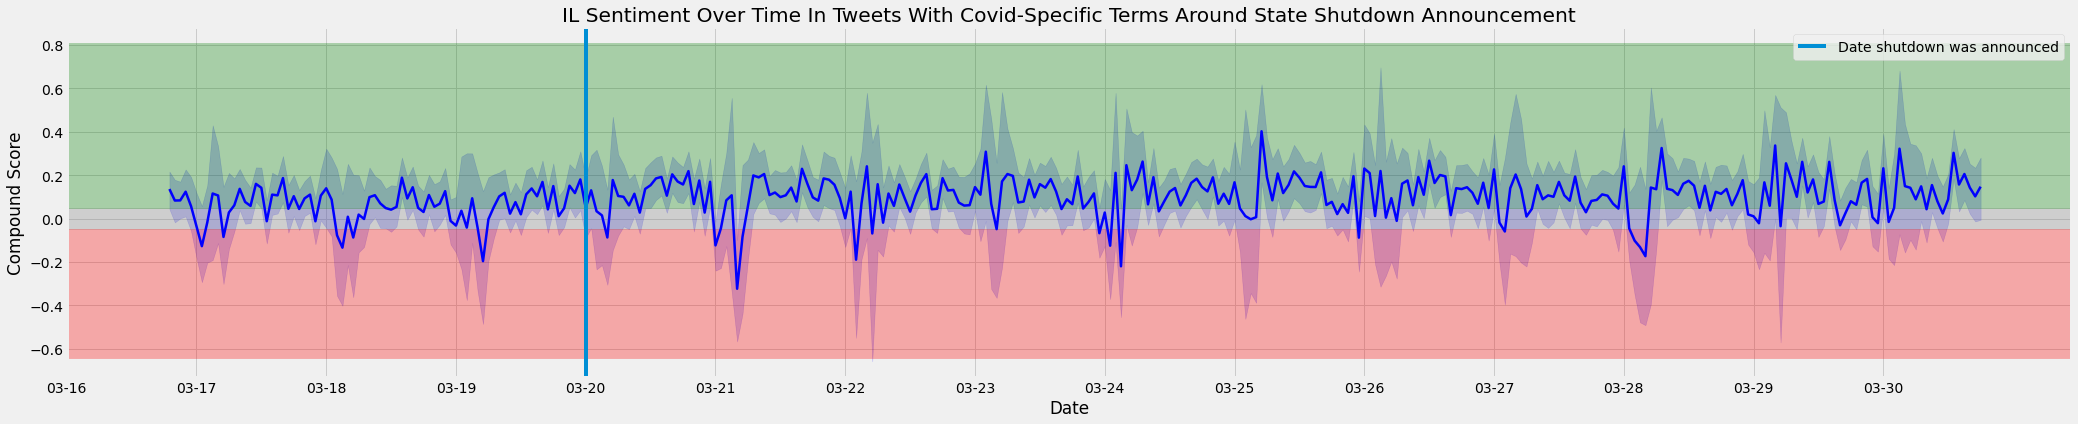

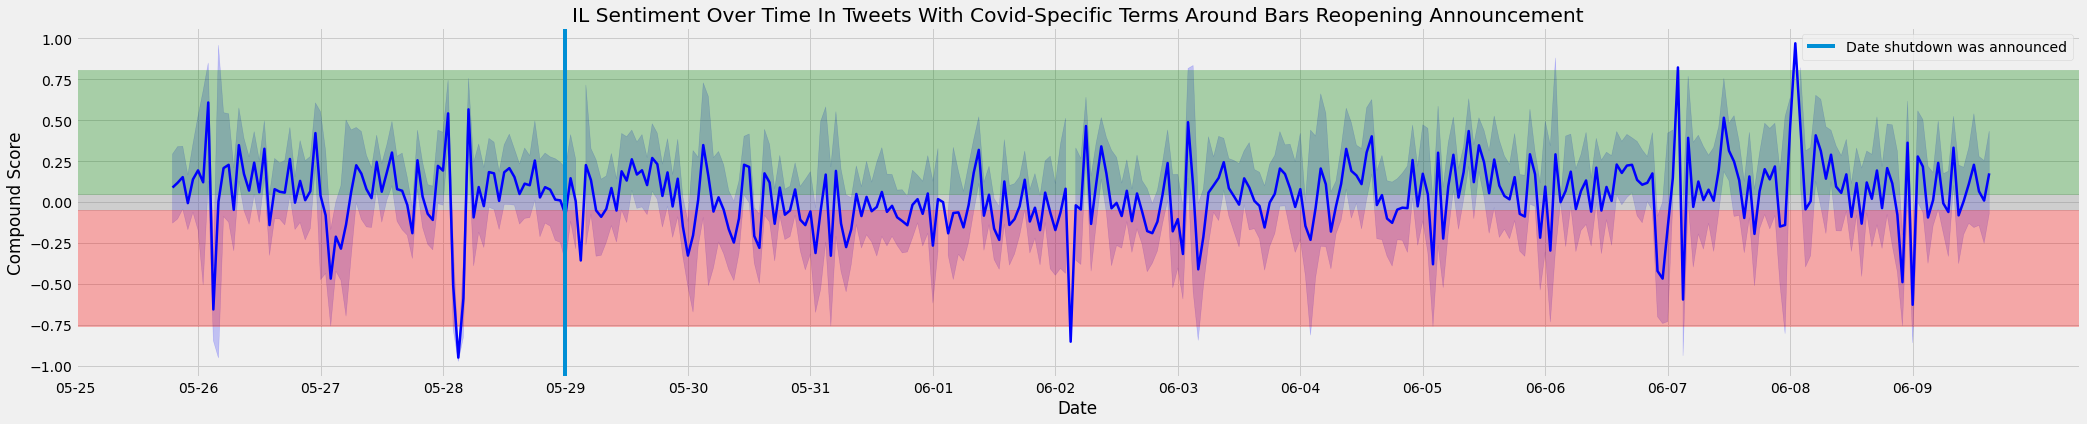

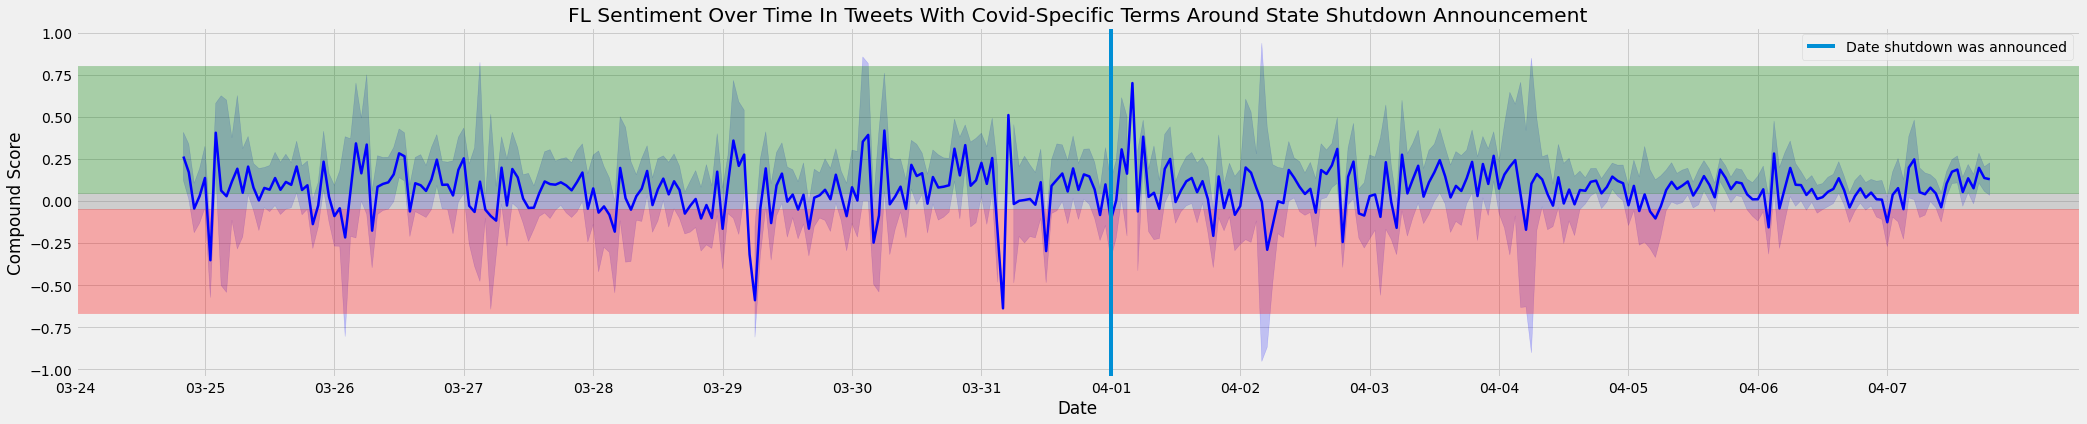

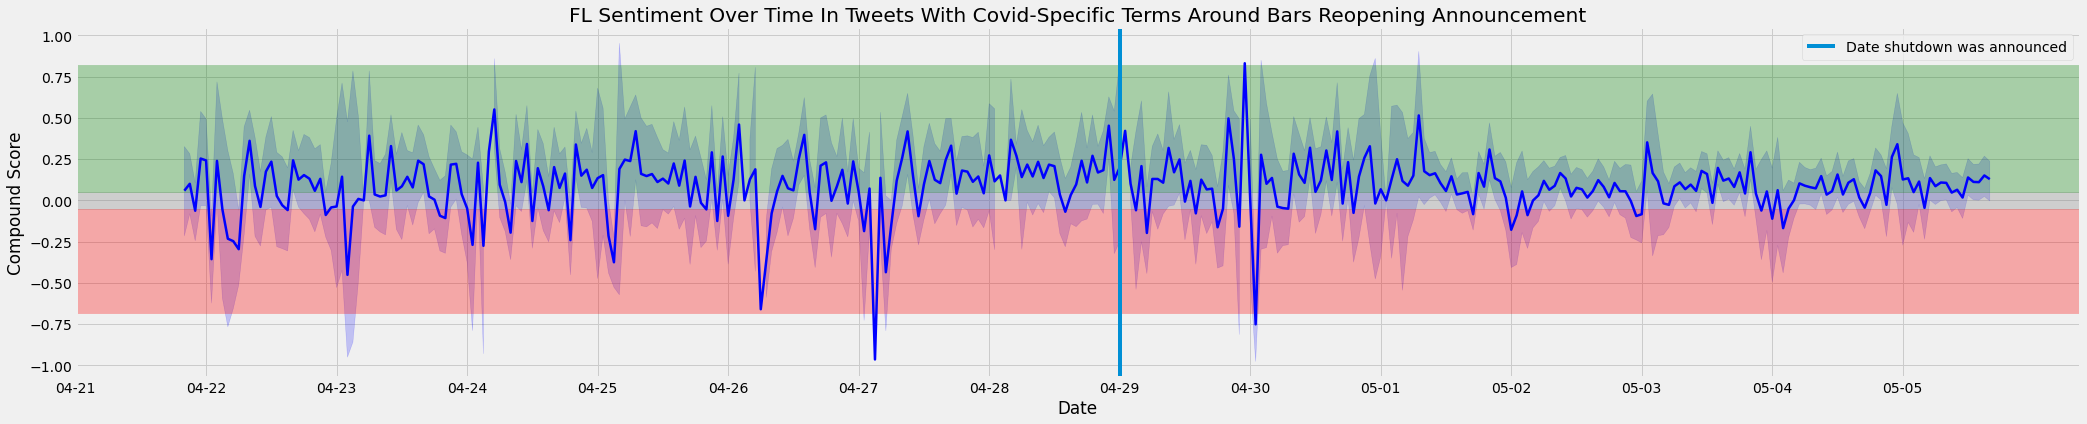

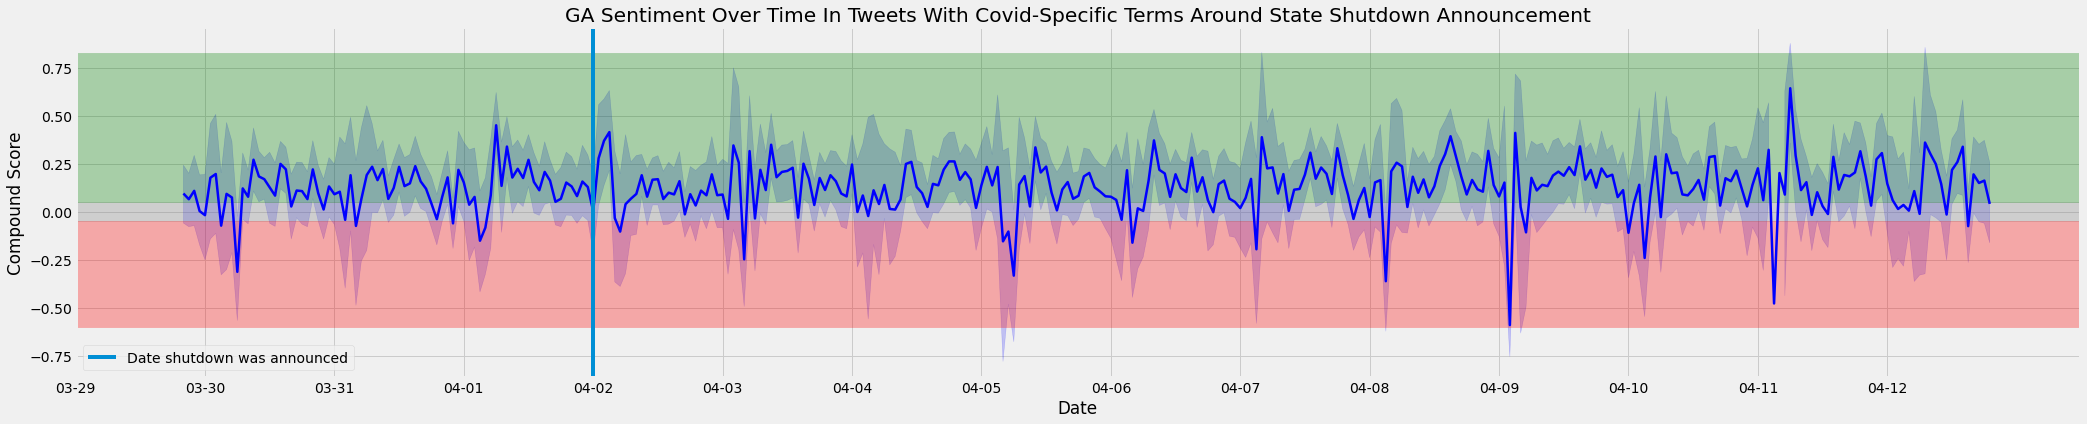

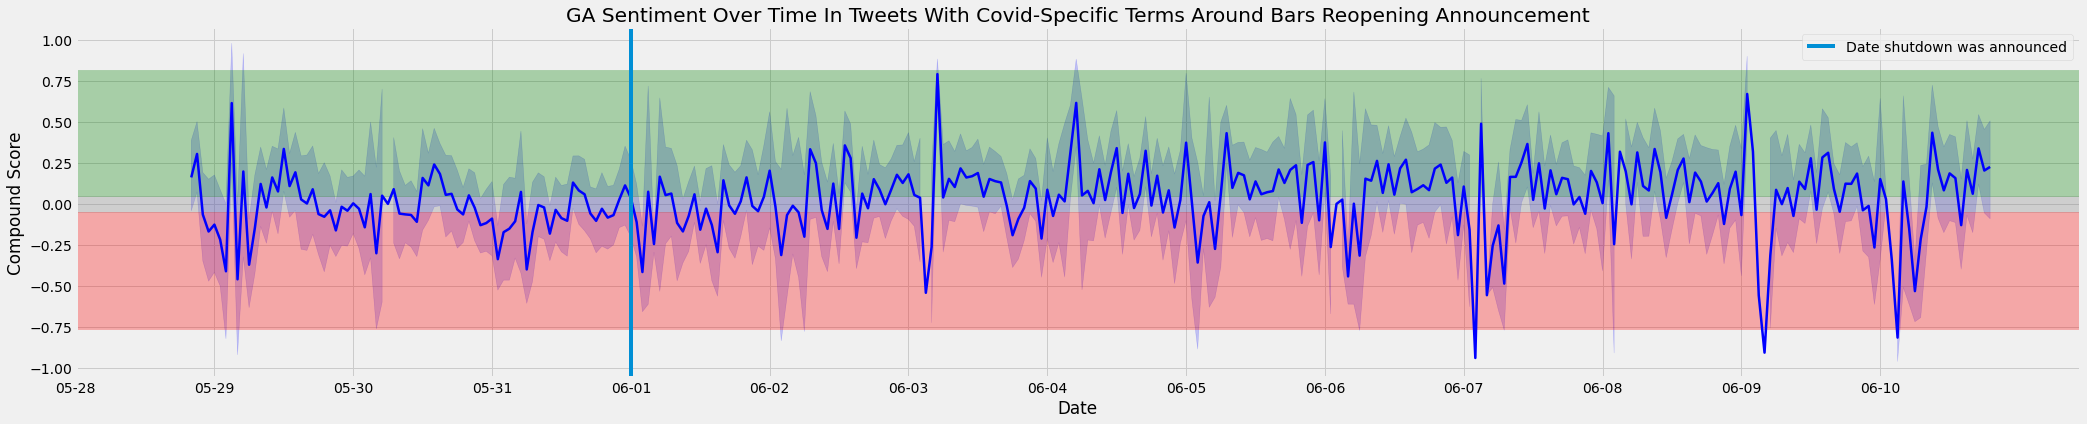

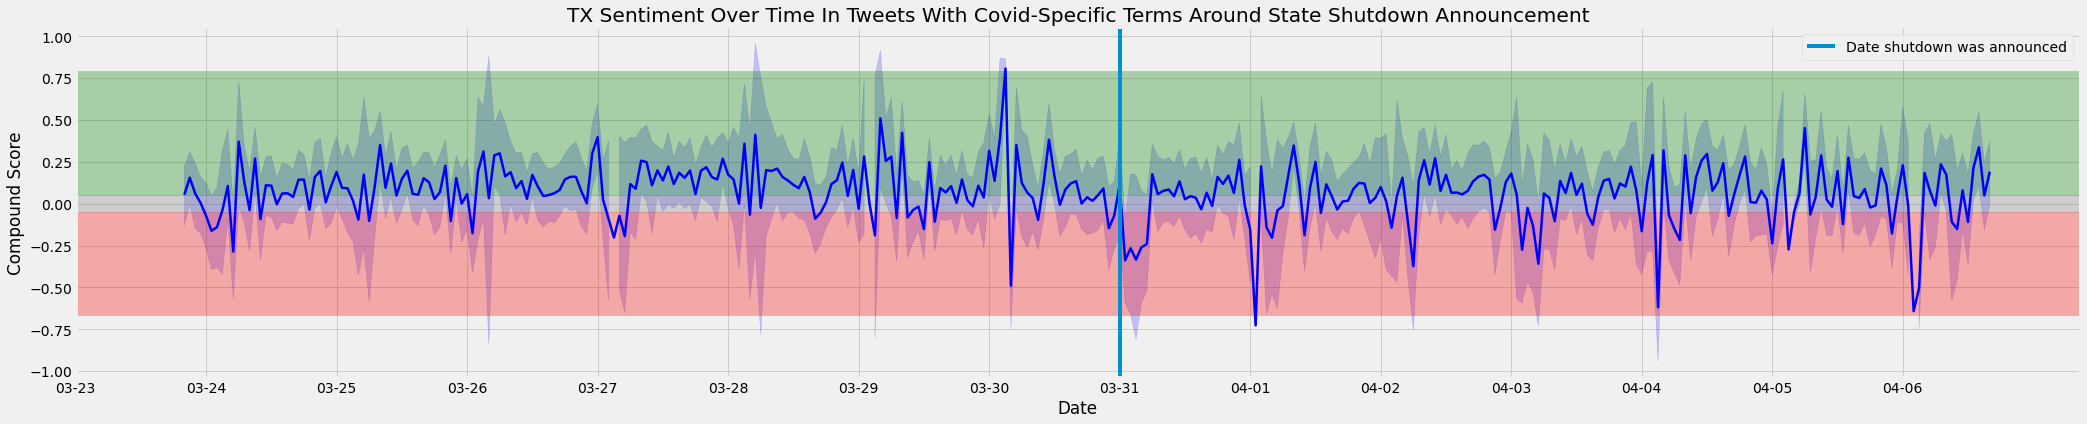

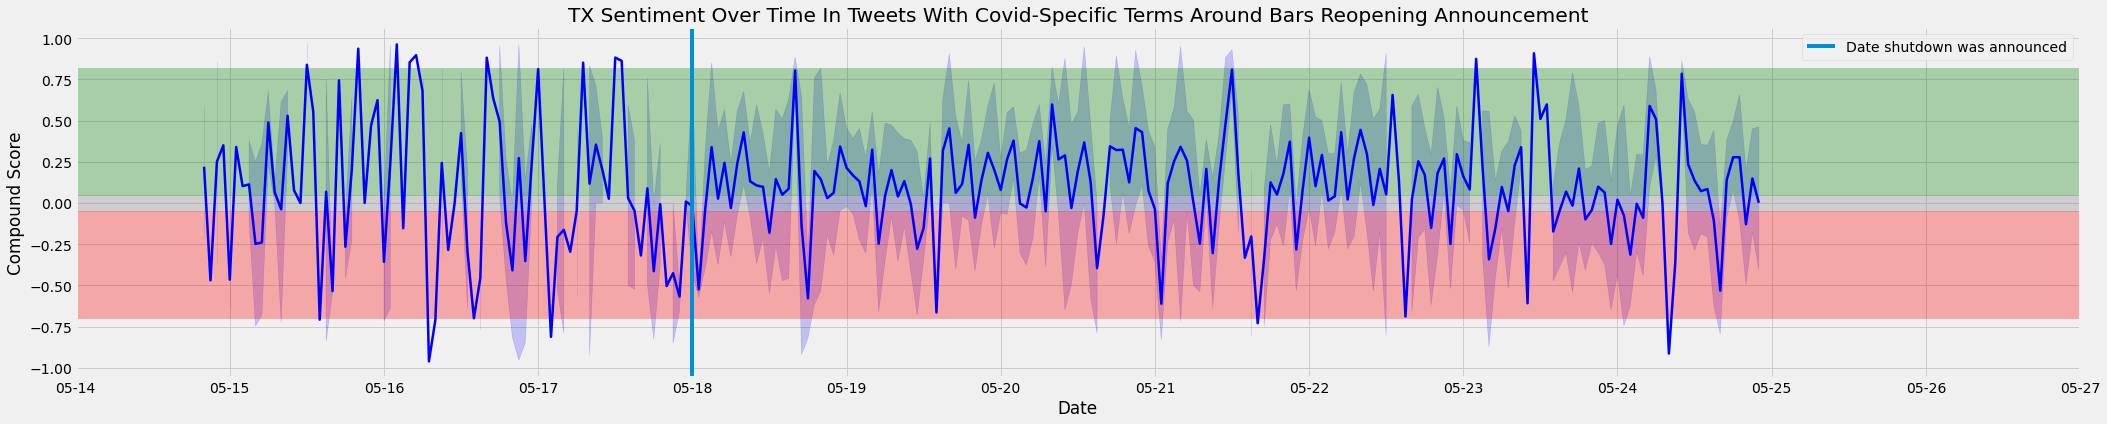

In [19]:
# Iterates through each item in covid_term_data and runs it through analyze_and_plot_sentiment

for i in range(len(covid_term_data)):
    analyze_and_plot_sentiment(covid_term_data[i][0], # data
                               covid_term_data[i][1], # timezone
                               covid_only=True, # search terms
                               is_reopen=covid_term_data[i][2] # whether or not state is reopen, this will change the vertical line's position on visual
                              )

## **General Sentiment from Tweets during shutdown and reopening phases**

In [32]:
# Dataframe, timezone, boolean for is_reopen
general_terms_data = [
    [il_shutdown_df, 'central', False],
    [il_reopen_df, 'central', True], 
    [ga_shutdown_df, 'eastern', False],
    [ga_reopen_df, 'eastern', True],
    [tx_shutdown_df, 'eastern', False],
    [tx_reopen_df, 'eastern', True],
    [mi_reopen_df, 'eastern', True],
    [mi_shutdown_df, 'eastern', False],
    [oh_reopen_df, 'eastern', True]
]

100%|██████████| 106971/106971 [00:00<00:00, 1201651.13it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:49: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000138A0A036C8> has a label of '_' which cannot be automatically added to the legend.
100%|██████████| 85646/85646 [00:00<00:00, 1172965.45it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:49: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001389E337948> has a label of '_' which cannot be automatically added to the legend.
100%|██████████| 69259/69259 [00:00<00:00, 1173629.69it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:49: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001389E34B148> has a label of '_' which cannot be automatically added to the legend.
100%|██████████| 86435/86435 [00:00<00:00, 1183763.47it/s]
C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:49: Use

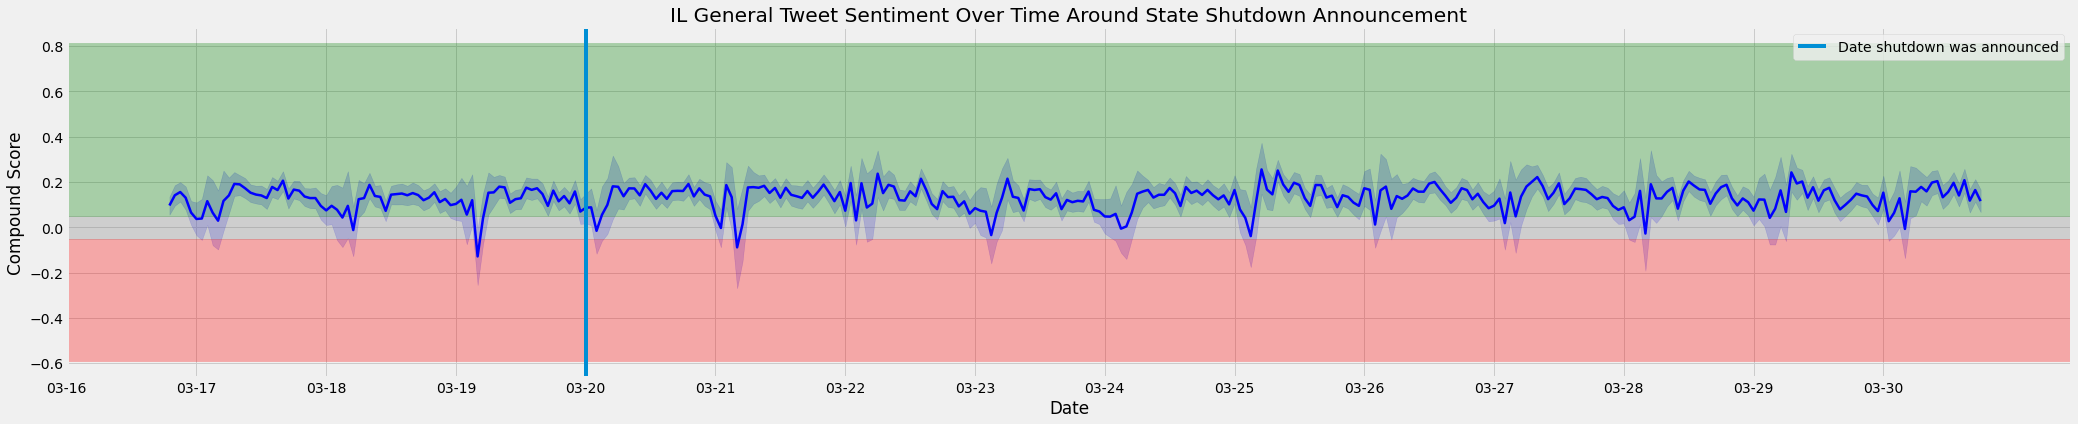

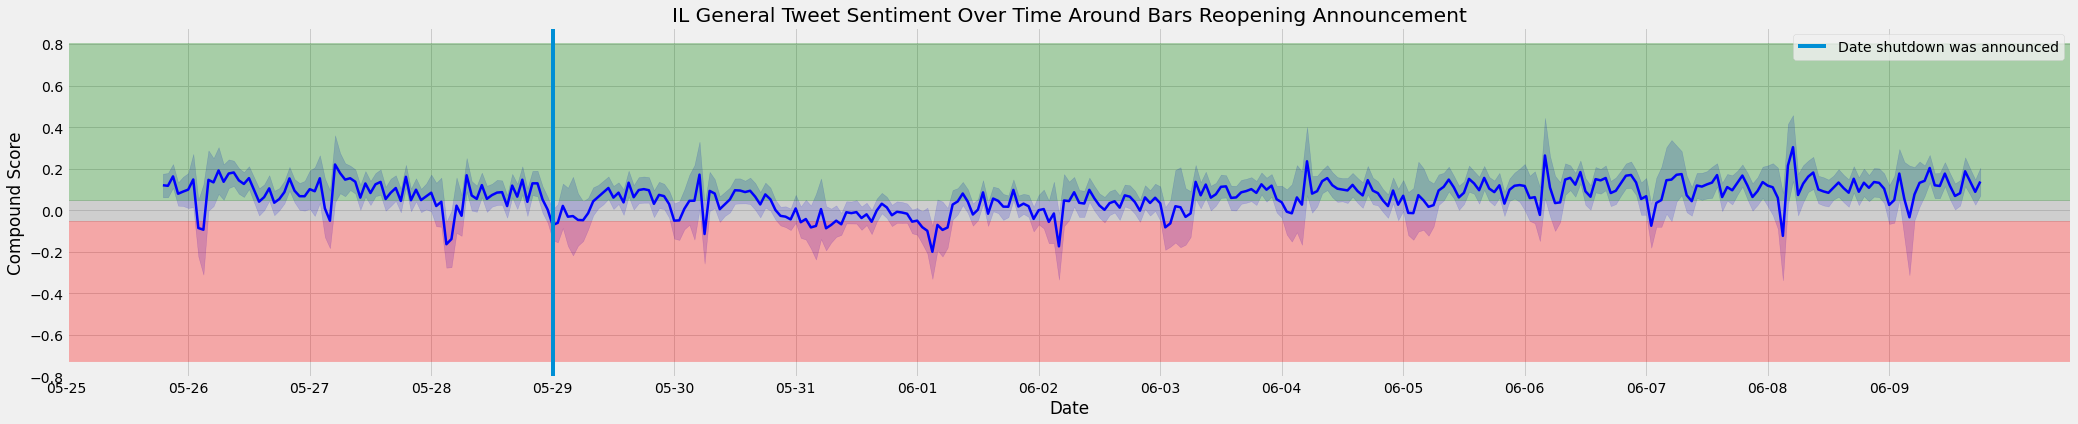

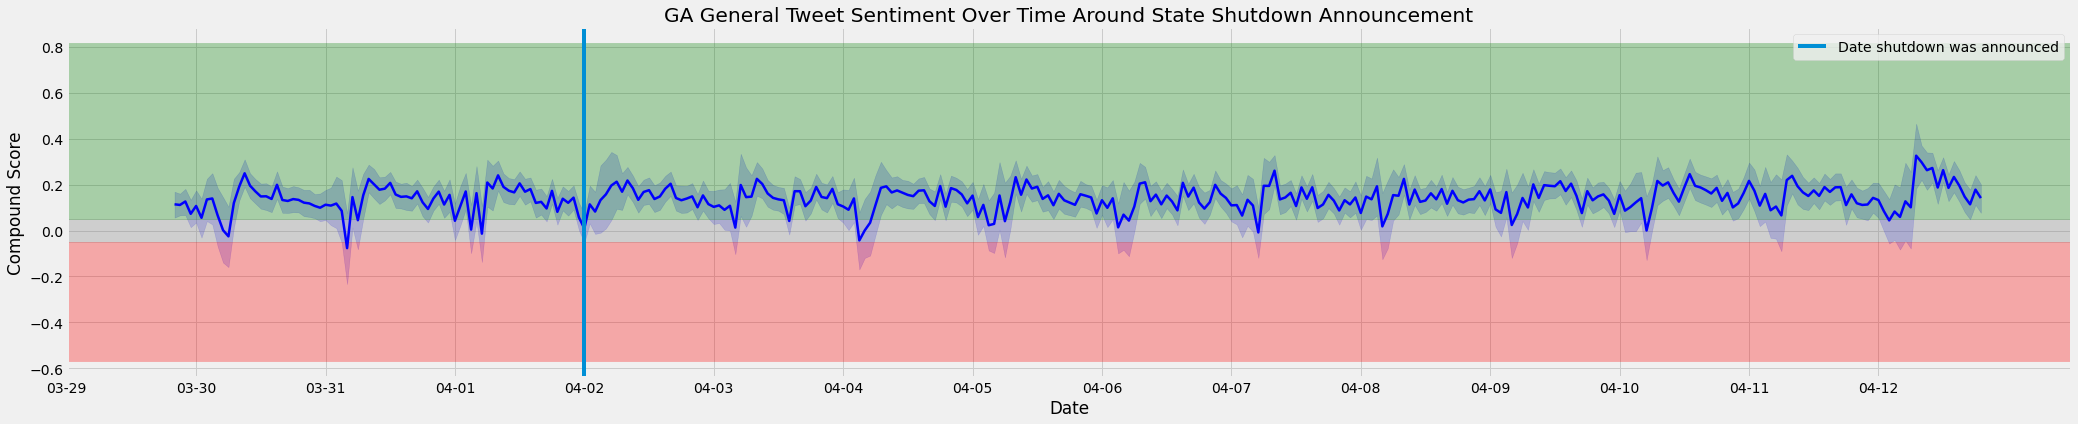

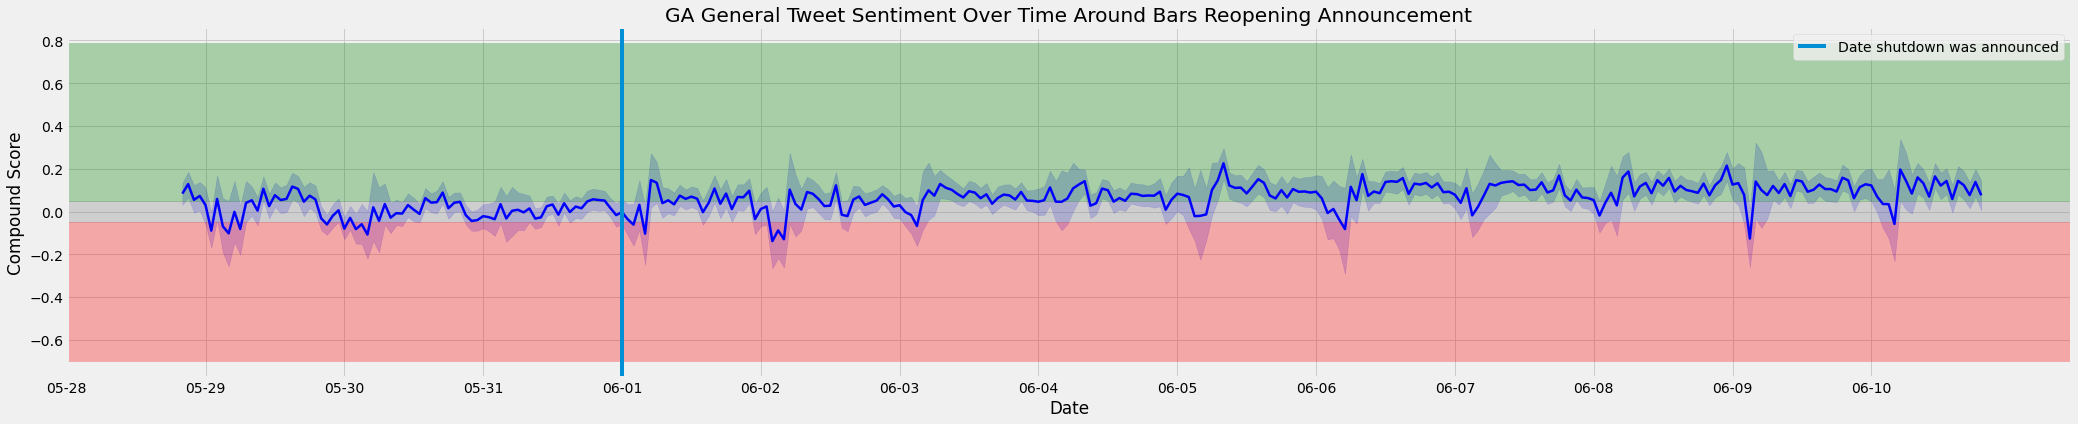

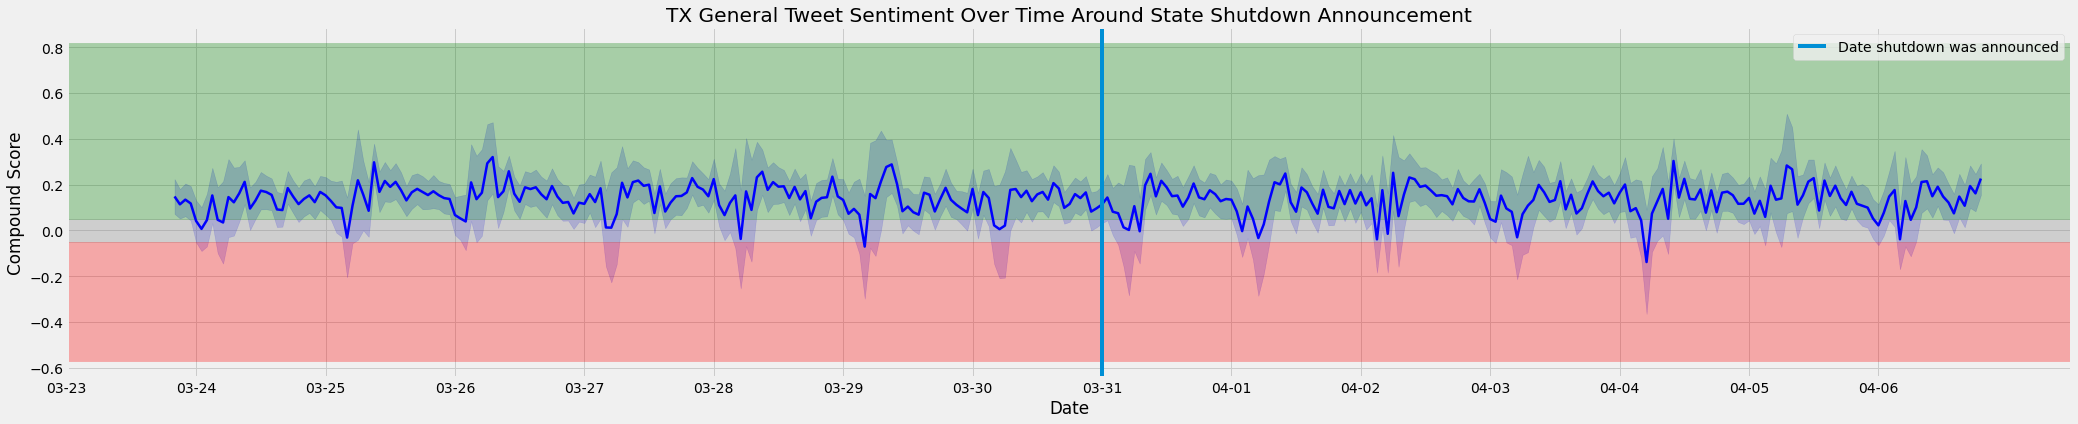

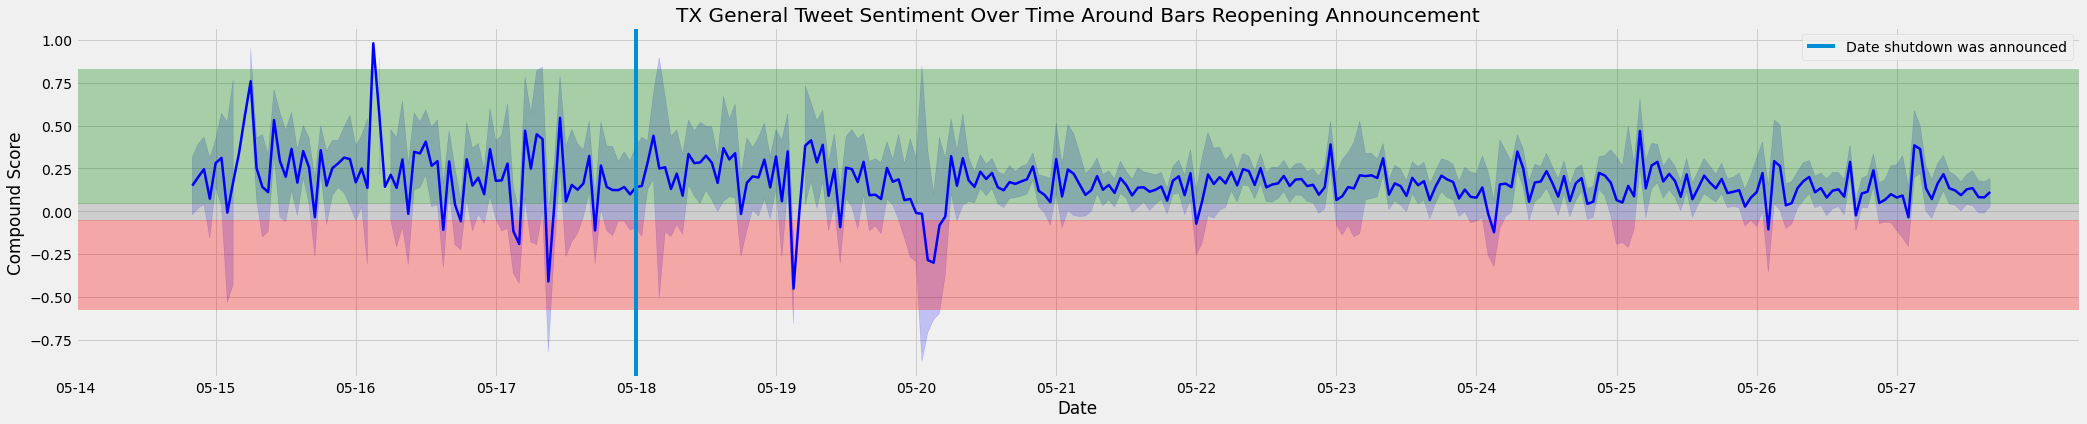

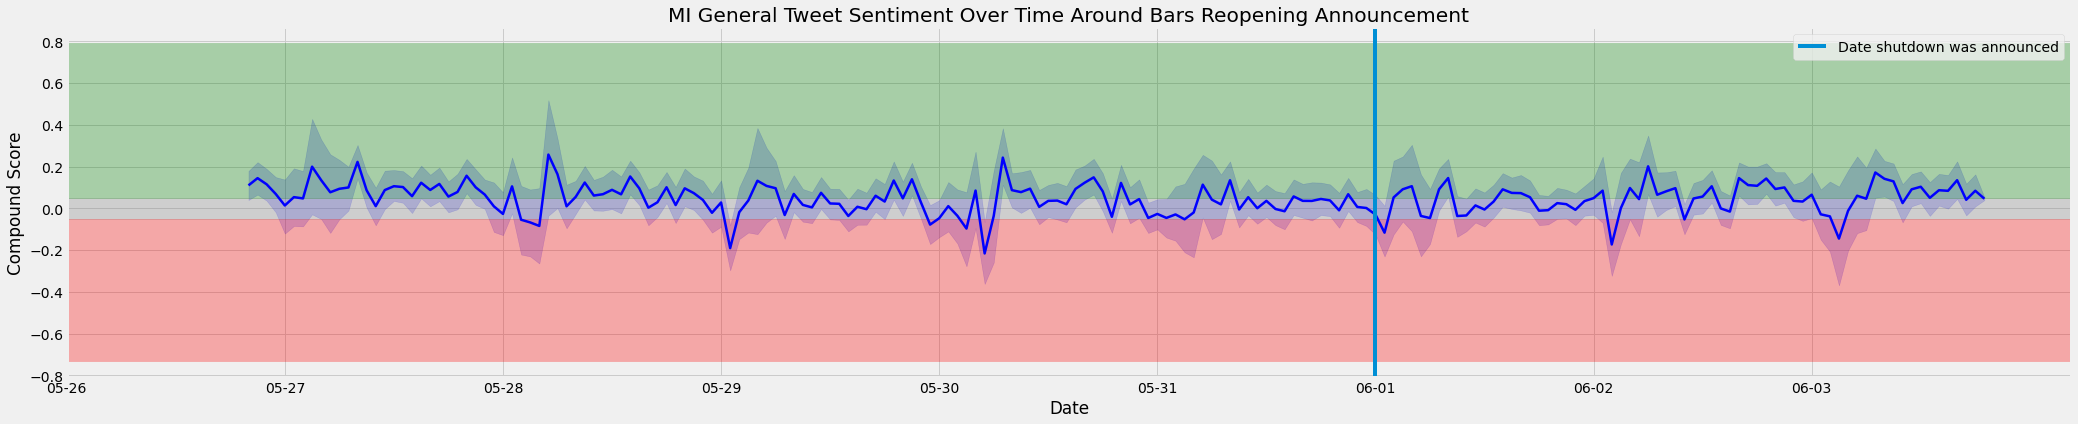

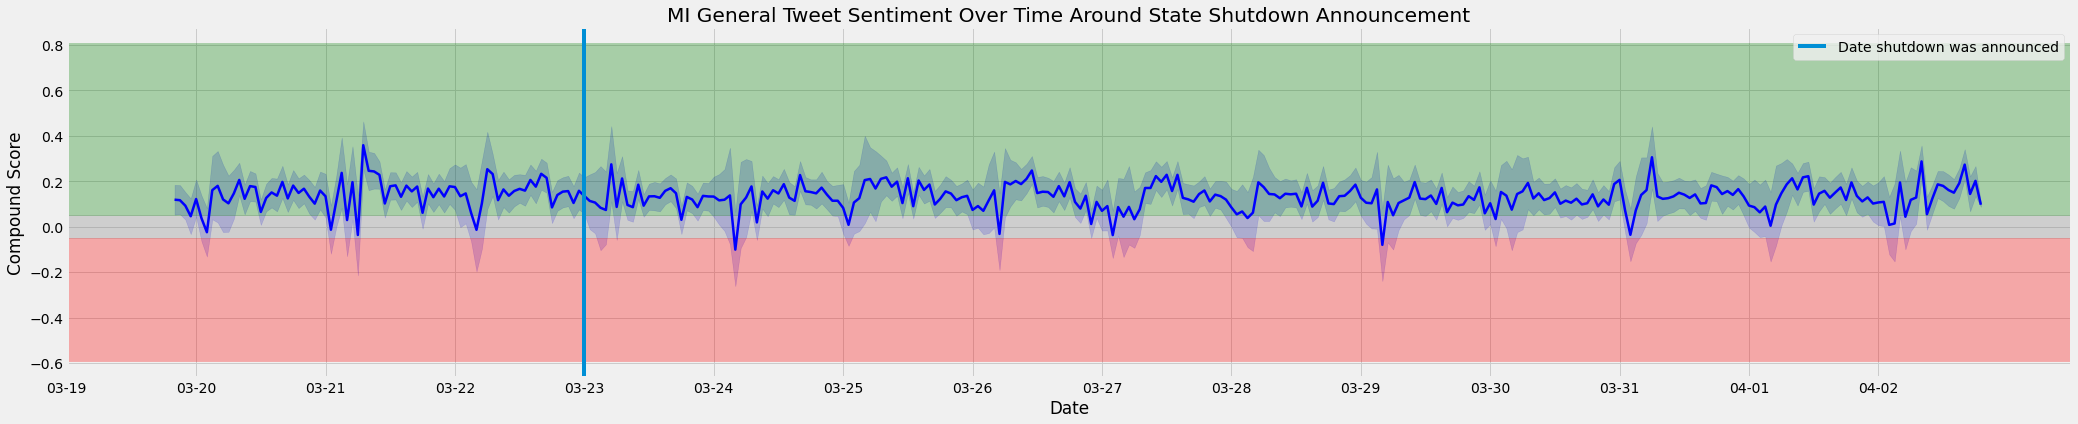

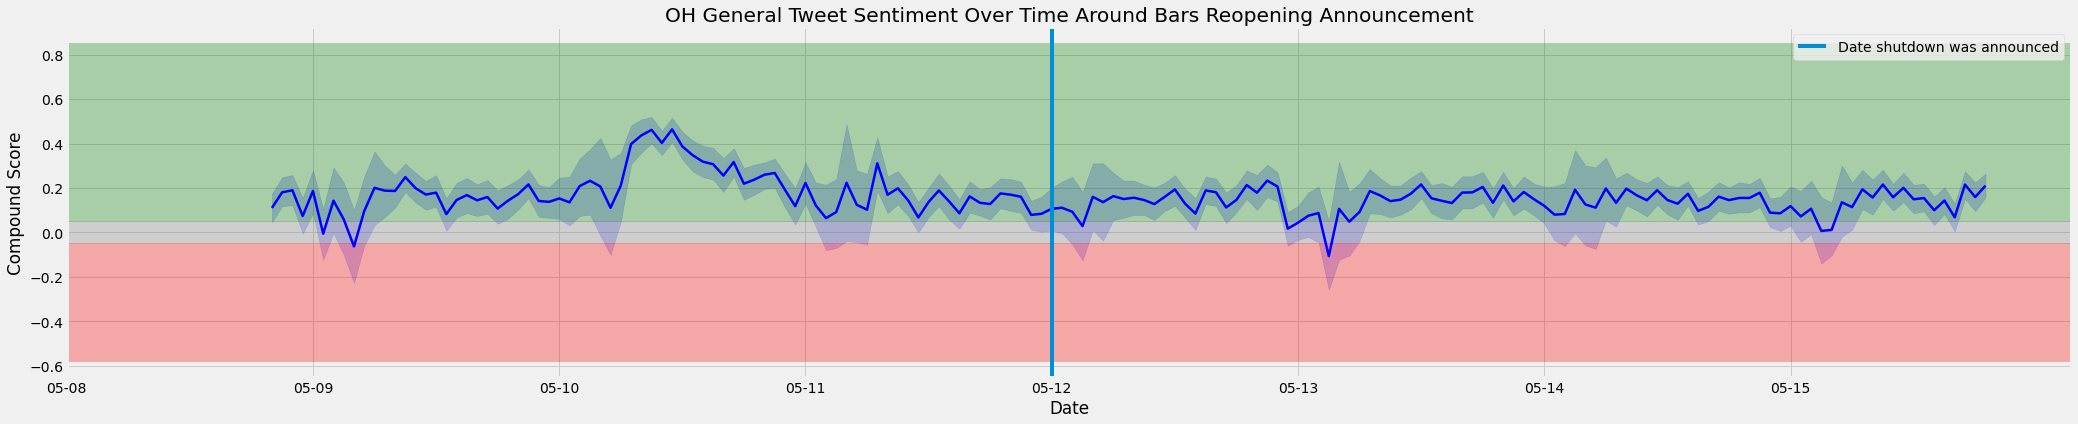

In [33]:
for i in range(len(general_terms_data)):
    analyze_and_plot_sentiment(general_terms_data[i][0], # data
                               general_terms_data[i][1], # timezone
                               covid_only=False, # search terms
                               is_reopen=general_terms_data[i][2] # whether or not state is reopen, this will change the vertical line's position on visual
                              )

## Insights from these visualizations

* There is **seasonality** to the data - average compound sentiment seems to move pretty drastically between the hours of **12am-4am daily**.
* The range of **average compound sentiment is larger when we only look at covid-specific terms**, and there is much more variability as compared to the covid + general tweet sentiment.
* Variability in sentiment may be due to the **number of tweets in an hour** - there are less people tweeting between the hours of 12-4am, and we see that the standard deviation (represented by the transparent blue area) is typically larger at these points

In [ ]:
# il_shutdown_df.to_csv(f.'{base_url}/IL_shutdown_sentiment.csv')
# ga_shutdown_df.to_csv(f.'{base_url}/GA_shutdown_sentiment.csv')
# tx_shutdown_df.to_csv(f.'{base_url}/TX_shutdown_sentiment.csv')
# mi_shutdown_df.to_csv(f.'{base_url}/MI_shutdown_sentiment.csv')

# oh_reopen_df.to_csv(f.'{base_url}/OH_reopen_sentiment.csv')
# il_reopen_df.to_csv(f.'{base_url}/IL_reopen_sentiment.csv')
# ga_reopen_df.to_csv(f.'{base_url}/GA_reopen_sentiment.csv')
# tx_reopen_df.to_csv(f.'{base_url}/TX_reopen_sentiment.csv')
# mi_reopen_df.to_csv(f.'{base_url}/MI_reopen_sentiment.csv')

## What's next?

Next up, we'll be combining all these data into one large .csv file to be used in Tableau